<a href="https://colab.research.google.com/github/AleemRahil/Robust-End-to-End-E-Commerce-Analytics-Automation-with-LLMs/blob/main/shopify_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Extracting Shopify Data for AI/ML & Analytics

In this project, I efficiently extracted Shopify data and laid the groundwork for building AI/ML and Advanced Analytics pipelines and products. This foundation will also pave the way for leveraging LLM frameworks such as LangChain, LLamaIndex, and Autogen to gain deeper insights into ecommerce data.

In [ ]:
!pip install -qU \
  python-dotenv \
  ShopifyAPI

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import json
import urllib.request
import pandas
import shopify
from dotenv import load_dotenv


# Load environment variables from a .env file
load_dotenv()

True

#Connecting With The Shopify GraphQL Client

We will extract and transform data from Shopify using the GraphQL API. Leveraging the GraphQL API allows us to interact directly with Shopify's data objects and enables precise data retrieval, in the sense that we can curate exactly the fields we need in every query.

To get started, you need to set up a Shopify development store and fetch an API key. You can follow this guide from Shopify (https://help.shopify.com/en/partners/dashboard/managing-stores/development-stores?ref=rabbitmetrics.com)

Once we have a valid API key with the right access scope, we use the python-dotenv package to load environment variables from a .env file into the script's environment. The load_dotenv() function searches for the environment file in the current directory or any of its parents and then loads the variables so they can be accessed using os.getenv().

After setting up environment variables to keep sensitive information safe, the next important step is to initiate a connection with Shopify's services. The shopify_client function plays a key role here, as it wraps up the steps needed to set up and configure a Shopify GraphQL client. This client acts as the main gateway for all the queries we send to Shopify's GraphQL API, letting us pull in detailed information about customers, orders, and products.

In [ ]:
def shopify_client(merchant, token):
    """
    Initialize a Shopify GraphQL client.
    """
    api_session = shopify.Session(merchant, '2023-01', token)
    shopify.ShopifyResource.activate_session(api_session)
    client = shopify.GraphQL()
    return client

The process of extracting data looks like the following

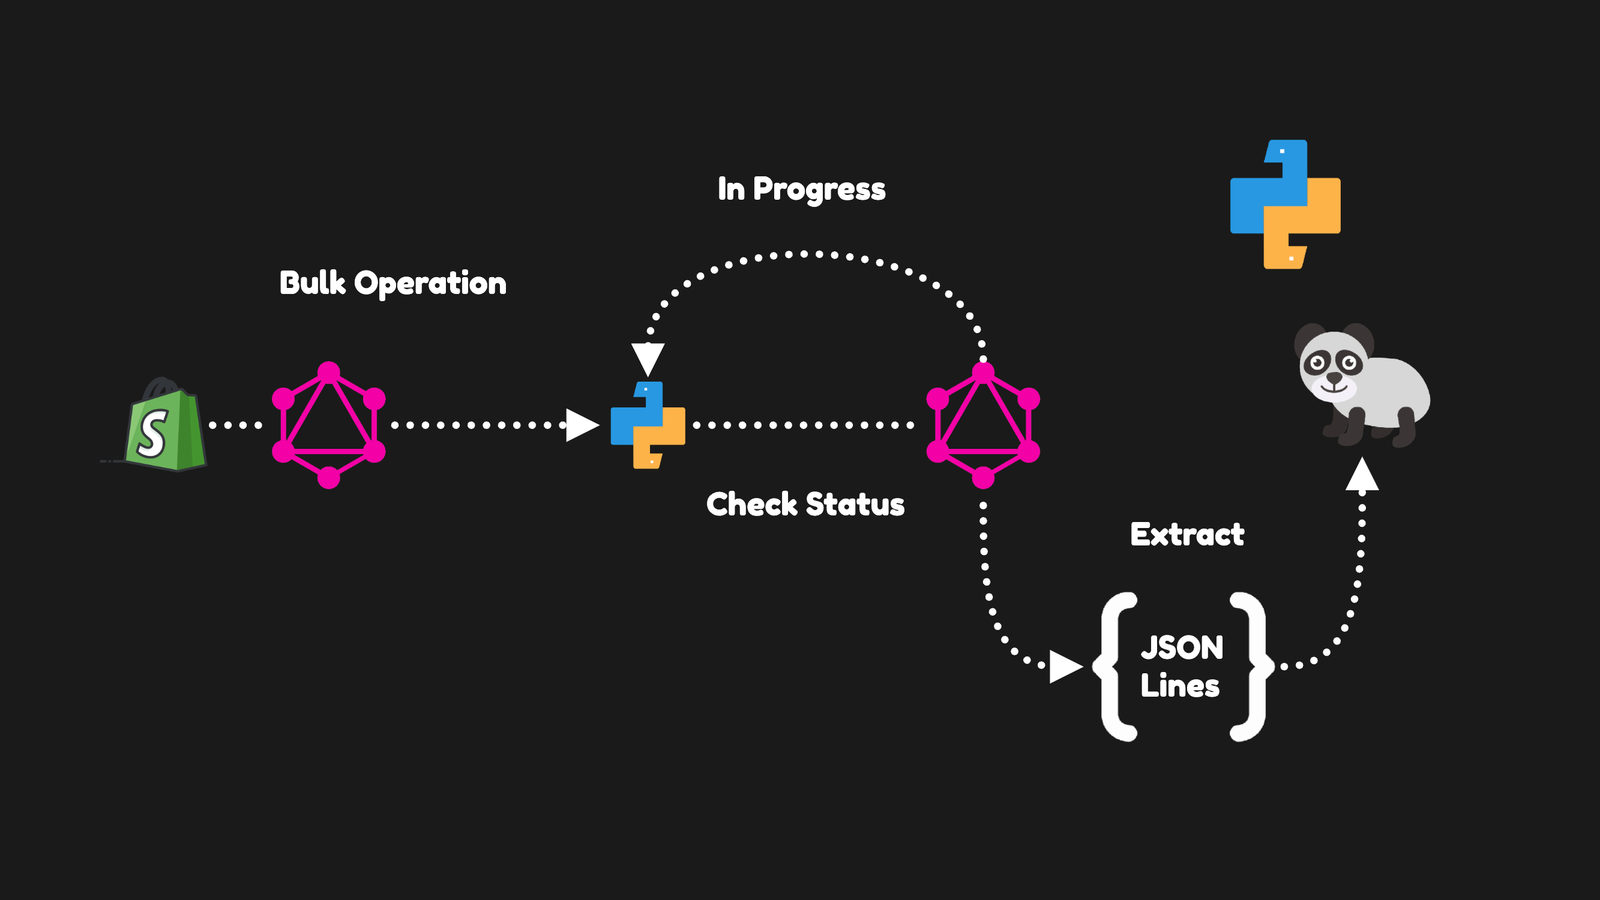

Here's a breakdown of the data extraction process:

1.   Initiate Bulk Operation: A GraphQL bulk operation is started on the Shopify platform to gather extensive datasets such as customer, order, and product information.

2.   Check Status: Periodically check the status of the bulk operation using a GraphQL query to determine if the operation is In Progress or Completed.

3.   Data Ready: Once the bulk operation isCompleted, a URL is provided to access the results.
4.   Fetch Data: Use the provided URL to fetch the data, which is formatted in JSON Lines (JSONL) – each line is a separate JSON object.

5.   Extract Data: Parse the JSONL data to separate the JSON objects into categories corresponding to customers, orders, and line items.
6.   Create DataFrames: Convert the categorized data into three separate pandas DataFrames for customers, orders, and line items, making the data ready for analysis and reporting.

This process efficiently moves data from Shopify's storage through a bulk operation to your local environment where it can be manipulated and analyzed with Pandas.

#Formulating GraphQL (Bulk) Queries

In [ ]:
# Modify the GraphQL queries to select important fields
customers_query = """
query {
  customers(first: 10) {
    edges {
      node {
        id
        firstName
        lastName
        orders(first: 10) {
          edges {
            node {
              id
              createdAt
              currentSubtotalLineItemsQuantity
              lineItems(first: 3) {
                edges {
                  node {
                    id
                    quantity
                    title
                    vendor
                    product {
                      id
                      description
                      handle
                    }
                    originalUnitPriceSet {
                      shopMoney {
                        amount
                      }
                    }
                  }
                }
              }
            }
          }
        }
      }
    }
  }
}
"""


This GraphQL query retrieves a focused dataset, including customer information, orders, and specific line items. Here I'm limiting the results to the first ten customers and their orders, and fetching up to three line items per order with product details and pricing, you can adjust this to your specific needs.

#Executing GraphQL Bulk Queries

Bulk operations allow for executing extensive queries asynchronously, which is particularly beneficial when dealing with significant amounts of data, such as retrieving comprehensive customer, order, and product information. The bulk_operation function encapsulates this process, preparing a GraphQL mutation for submission.

In [ ]:
# Wrap the main query in a bulk operation

def bulk_operation(query):
    q = """
        mutation {
          bulkOperationRunQuery(
            query:""" + json.dumps(query) + """
          ) {
            bulkOperation {
              id
              status
            }
            userErrors {
              field
              message
            }
          }
        }
    """
    return q

This function takes a GraphQL query as input and constructs a mutation request for Shopify's bulk operation. The query is serialized into a JSON string and embedded within the mutation. This setup triggers Shopify to process the query in the background, allowing for the retrieval of large volumes of data without overloading the client or the server.

Once submitted, Shopify provides an operation ID and status, which can be used to track the progress of the bulk operation.

Following the initiation of a bulk operation, monitoring the operation's progress is the next step. Here I've written a GraphQL query and a Python function designed to check the status of the submitted bulk operation. This ensures that we can check that the operation is completed successfully before proceeding to data extraction.

In [ ]:
# Check the status of the running bulk operation

q_bulk_status = """
query bulkStatus($id: ID!) {
  node(id: $id) {
    ... on BulkOperation {
      id
      status
      errorCode
      createdAt
      completedAt
      objectCount
      fileSize
      url
      partialDataUrl
    }
  }
}
"""

def bulk_status(client, bulk):
    bulk_id = json.loads(bulk)['data']['bulkOperationRunQuery']['bulkOperation']['id']
    status = json.loads(client.execute(q_bulk_status, {'id': bulk_id}))
    return status

We have two main components needed for fetching bulk data:

1.   GraphQL Query for Bulk Operation Status: A query to fetch the current status of a bulk operation using its unique ID. The query is designed to retrieve not only the status but also additional details such as error codes, timestamps of creation and completion, and metrics related to the operation's output (e.g., object count, file size, and URLs for result retrieval).
2.   Python Function for Status Check: A function named bulk_status that utilizes the Shopify GraphQL client to execute the status query. By parsing the initial bulk operation response to extract the operation ID and then querying for its status, users can determine whether the operation is complete and if it's safe to proceed with data handling.

Following the setup for initiating and monitoring bulk operations, the next step involves executing these operations to fetch the data from the store. This process is encapsulated in the execution of a bulk operation using the previously defined GraphQL query and the subsequent monitoring of its status:

In [ ]:
bulk_query = bulk_operation(customers_query)

bulk = client.execute(bulk_query)

status = bulk_status(client, bulk)

Here's a breakdown of each step:

*   Initiating the Bulk Operation: The bulk_operation function is called with customers_query as its argument. This function prepares a GraphQL mutation for initiating a bulk operation with the specified query, which is designed to fetch detailed customer and order data.
*   Executing the Bulk Operation: The prepared mutation (bulk_query) is then executed against Shopify's GraphQL API using the execute method of the Shopify GraphQL client (client). This action submits the bulk operation to Shopify, which processes the query asynchronously.

*   Checking the Operation Status: Immediately after the bulk operation is submitted, its status is checked by calling the bulk_status function with the response from the execution step. This function extracts the operation ID from the initial response and queries Shopify for the current status of the bulk operation.

Once the bulk operation is completed, the resulting data can be processed and analyzed

#From Shopify to Pandas

In [ ]:
# Set up environment variables for Shopify credentials
merchant= os.getenv('SHOPIFY_MERCHANT')
token = os.getenv('SHOPIFY_TOKEN')

# Initialize the Shopify GraphQL client with credentials
client = shopify_client(merchant, token)

# Prepare and execute the bulk operation using a GraphQL query
bulk_query = bulk_operation(customers_query)
bulk = client.execute(bulk_query)

# Monitor the status of the bulk operation
status = bulk_status(client, bulk)

The final step in the process of extracting and analyzing data from Shopify involves parsing the bulk operation's results and structuring this data into a more accessible format.

The following function fetch_and_prepare_data serves this purpose by organizing the data into lists of customers, orders, and line items:

In [ ]:
# Fetch data from the completed bulk operation and return the data in Pandas dataframes

def fetch_and_prepare_dataframes(bulk_status):
    customers = []
    orders = []
    lineitems = []
    if bulk_status['data']['node']['status'] == 'COMPLETED':
        url = bulk_status['data']['node']['url']
        with urllib.request.urlopen(url) as mydata:
            for line in mydata:
                line_dict = json.loads(line.decode('utf8'))
                # Determine the type and append to the appropriate list
                if '__parentId' not in line_dict:
                    customers.append(line_dict)
                else:
                    child_id = line_dict['id']
                    if 'Order' in child_id:
                        orders.append(line_dict)
                    elif 'LineItem' in child_id:
                        lineitems.append(line_dict)

    # Convert lists to pandas DataFrames
    customers_df = pd.DataFrame(customers)
    orders_df = pd.DataFrame(orders)
    lineitems_df = pd.DataFrame(lineitems)

    return customers_df, orders_df, lineitems_df

Given a complete bulk operation, we can now extract the needed data:

In [ ]:
# Fetch the data
customers_df, orders_df, lineitems_df = fetch_and_prepare_dataframes(status)

This will give us the following three dataframes to work with:

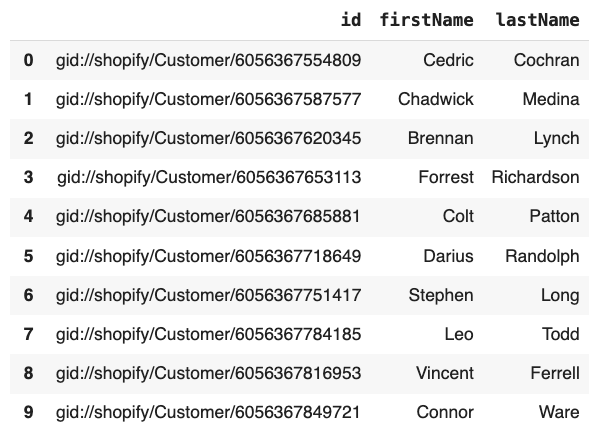

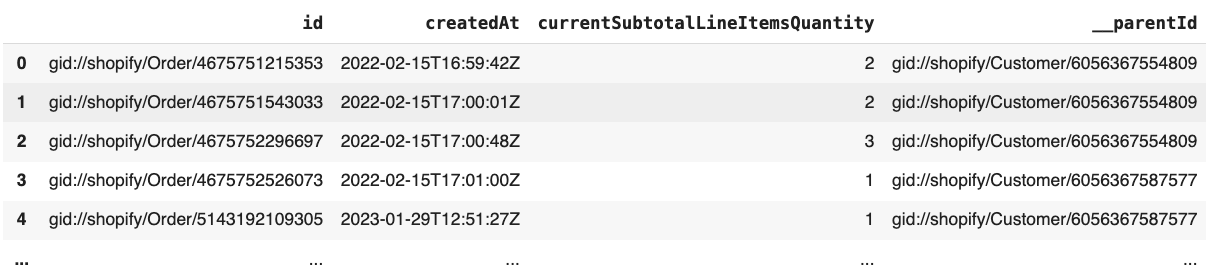

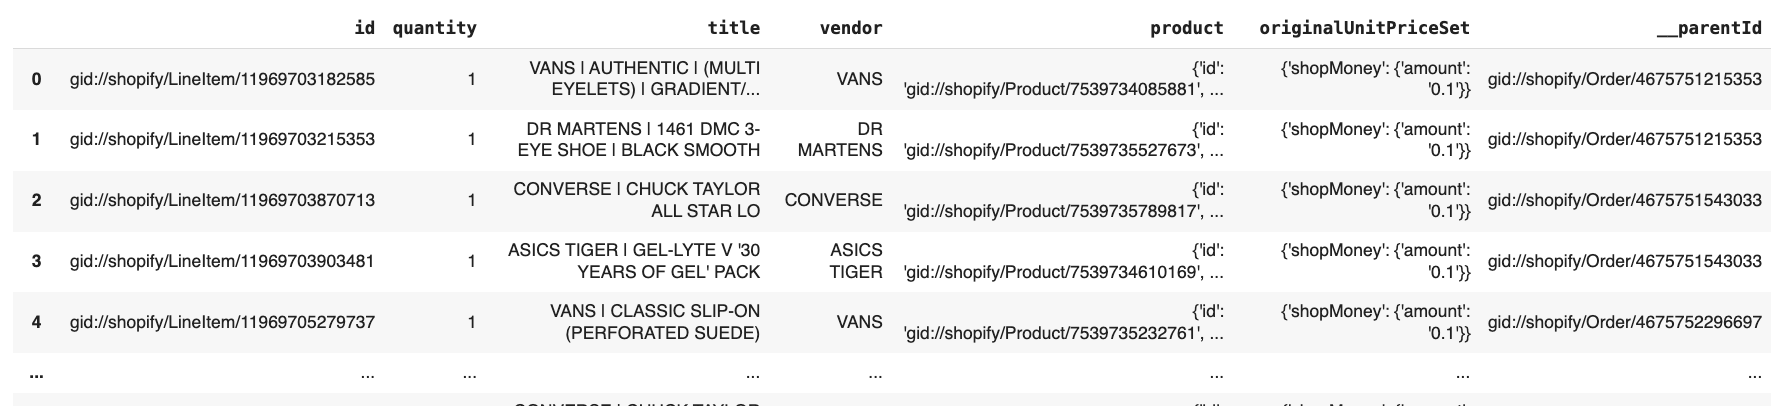

#Key Steps:

*   Data Parsing: The function iterates through the nested JSON structure returned by the bulk operation, extracting relevant details about customers, their orders, and the line items within those orders. Each entity is then appended to its respective list.
*   Data Structuring: After parsing, the data for customers, orders, and line items is structured into separate lists, which are then converted into pandas DataFrames. This conversion is crucial for enabling advanced data manipulation and analysis capabilities.

*   DataFrame Conversion: Converting the lists into DataFrames (customers_df, orders_df, lineitems_df) allows for leveraging pandas' powerful data analysis and manipulation tools. DataFrames provide a tabular representation of the data, facilitating operations such as filtering, sorting, and aggregating.
This process effectively turns the raw JSONL data from Shopify's bulk operation into structured, analyzable datasets. These dataframes can now form the basis for generating insights, building dashboards, and developing advanced AI/ML pipelines.
